In [1]:
%reset
import sys, platform, os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pdb
import healpy as hp
from astropy.io import fits
import time
import math
from scipy import interpolate
import pickle as pk
import treecorr
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
# import astropy.constant as c
# sys.path.insert(0,'/home/shivam/Research/cosmosis/cosmosis-des-library/tcp/3d_stats')
import pk_to_xi_fast_toimp as ptx
likef = __import__('3d_like_toimp')
cosmo_des = FlatLambdaCDM(H0=100, Om0=0.283705720011)
cosmo_pl = FlatLambdaCDM(H0=100, Om0=0.3158)
import copy

#see http://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

%matplotlib inline




Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
pklin_file = 'pkz_lin_MICE_cosmo.npz'
pknl_file = 'pkz_nl_MICE_cosmo.npz'
nz_dir = '/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/nz_data/'
data_file = '/Users/shivam/Dropbox/Research/bias_des/3d_to_2d/measurements/gg_mm__gm_mm_datavec_3dcorr_r_0.8_50.0_nr_20_zbin_1_2_3_4_5_jk_True_njk_180.pk'






In [4]:
data = pk.load(open(data_file, 'rb'))
r_obs, data_obs, cov_obs = data['sep'], data['mean'], data['cov']
bins_all = [1, 2, 3, 4, 5]
bins_to_fit = [3]

bins_to_rem = copy.deepcopy(bins_all)
for bins in bins_to_fit:
    bins_to_rem.remove(bins)

stat_type = 'gg_mm__gm_mm'




In [5]:
r_obs_new, data_obs_new, cov_obs_new = likef.import_data(r_obs, data_obs, cov_obs, bins_to_rem, bins_to_fit, bins_all,stat_type)





In [6]:
k_hres_min =  0.0001
k_hres_max =  100
n_k_hres_bin = 50000


r_array = r_obs_new[0]
k_hres = np.logspace(np.log10(k_hres_min), np.log10(k_hres_max), n_k_hres_bin)
reg_c = 10.0

output_nl_grid= True
pt_type = 'oneloop_eul_bk'

    

In [7]:


Pkz_lin_f = np.load(pklin_file)
Pkz_nl_f = np.load(pknl_file)
klin, zlin, Pkzlin = Pkz_lin_f['k'], Pkz_lin_f['z'], Pkz_lin_f['pkz']
knl, znl, Pnl_kz = Pkz_nl_f['k'], Pkz_nl_f['z'], Pkz_nl_f['pkz']




In [8]:

znl = np.array([znl[0]])
zlin = znl
Pkzlin = np.array([Pkzlin[0,:]])
Pnl_kz = np.array([Pnl_kz[0,:]])



In [9]:
Pk_terms_names = ['Plin', 'Pmm', 'Pd1d2', 'Pd2d2', 'Pd1s2', 'Pd2s2', 'Ps2s2', 'Pd1d3nl', 'k2Pk', 'sig4']

xi_gg = np.zeros((len(Pk_terms_names), len(znl), len(r_array)))
    


In [10]:
Pkth_array, karray = ptx.get_Pktharray(output_nl_grid, klin, knl, Pkzlin, Pnl_kz,pt_type=pt_type,Pk_terms_names = Pk_terms_names, z_array=znl)

Pkth_array_khres = np.zeros((len(Pk_terms_names), len(znl), len(k_hres)))



Initializing k-grid quantities...
Warning, you selected a extrap_low that is greater than k_min. Therefore no extrapolation will be done.


/Users/shivam/anaconda/lib/python2.7/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/shivam/anaconda/lib/python2.7/site-packages/scipy/fftpack/basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/Users/shivam/anaconda/lib/python2.7/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dty

In [11]:
import scipy.interpolate as interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline as intspline
import scipy.interpolate as interp

do_regularize_pk = True
do_reg_all = False
for j1 in range(len(Pk_terms_names)):

    print 'processing Pk ' + str(Pk_terms_names[j1])

    P_gg_khres = np.zeros((len(znl), len(k_hres)))
    for i in range(len(znl)):
        P_gg_j1_i = Pkth_array[j1][i, :]

        Pgg_temp = intspline(karray, P_gg_j1_i)
        Pgg_term_interp = Pgg_temp(k_hres)
        P_gg_khres[i, :] = Pgg_term_interp

    if Pk_terms_names[j1] == 'Plin':
        P_gg_khres_reg = P_gg_khres
    else:
        if do_regularize_pk:
            if do_reg_all:
                # P_gg_khres_reg = reg_Pk(P_gg_khres, P_lin_khres, k_hres, reg_k, c_val=reg_c)
                P_gg_khres_reg = ptx.reg_Pk_mat_expmult(P_gg_khres,k_hres,reg_c)
            else:
                if Pk_terms_names[j1] == 'k2Pk':
                    # P_gg_khres_reg = reg_Pk(P_gg_khres, P_lin_khres, k_hres, reg_k, c_val=reg_c)
                    # P_gg_khres_reg = reg_Pk_gaussian(P_gg_khres, k_hres, reg_k, c_val=reg_c)
                    P_gg_khres_reg = ptx.reg_Pk_mat_expmult(P_gg_khres, k_hres, reg_c)
                else:
                    P_gg_khres_reg = P_gg_khres
        else:
            P_gg_khres_reg = P_gg_khres

    if Pk_terms_names[j1] != 'sig4':
        for k in range(len(r_array)):
            xi_gg_f = ptx.Pk2corr_mat(r_array[k], k_hres, P_gg_khres_reg)
            xi_gg[j1, :, k] = xi_gg_f

    Pkth_array_khres[j1, :, :] = P_gg_khres_reg

    

    

    
    

processing Pk Plin
processing Pk Pmm
processing Pk Pd1d2
processing Pk Pd2d2
processing Pk Pd1s2
processing Pk Pd2s2
processing Pk Ps2s2
processing Pk Pd1d3nl
processing Pk k2Pk
processing Pk sig4


In [12]:
xi_all = xi_gg
# xi_mm = xi_all[1]
Pk_mm = Pkth_array_khres[1]
z_pk = znl



In [13]:


param_name = ['b1E', 'b2E', 'bsE', 'b3nlE', 'bkE']
# param_array_bin1 = [2.0,1.0,0.8,0.5,-1.0]
b1E_def = 1.5524
# b1E_def = 1.25
param_array_bin1 = [b1E_def,0.216,(-4./7.)*(b1E_def-1),(b1E_def - 1),0.0]
param_array_bin2 = param_array_bin1





In [14]:
Pk_gg, _ = ptx.get_PXX_terms_bins(param_array_bin1, param_array_bin2, Pkth_array_khres,pt_type=pt_type)
Pk_gm, _ = ptx.get_PXm_terms(param_array_bin1, Pkth_array_khres,pt_type=pt_type)

xi_gg, xi_gg_terms = ptx.get_xiXX_terms_bins(param_array_bin1, param_array_bin2, xi_all,pt_type=pt_type)
xi_gm, xi_gm_terms = ptx.get_xiXm_terms(param_array_bin1, xi_all,pt_type=pt_type)
xi_mm = xi_all[1]


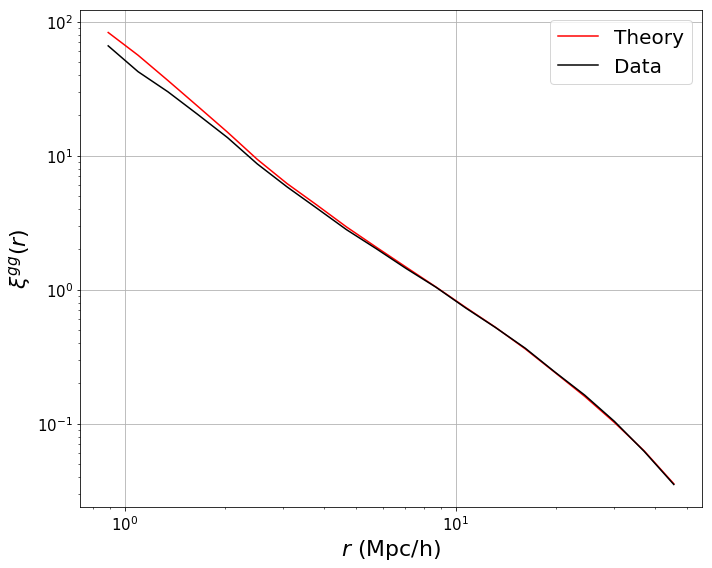

In [15]:
fig, ax = plt.subplots(1,1, figsize = (10,8))


ax.plot(r_obs_new[0],xi_gg[0], color = 'r', marker='',linestyle='-',label=r'Theory')
ax.plot(r_obs_new[0],data_obs_new[0:20]*xi_mm[0], color = 'k', marker='',linestyle='-',label=r'Data')


ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(1.0,12.0)
ax.grid()
# ax.set_xlabel(r'$\theta$', size = 18)
ax.set_ylabel(r'$\xi^{gg}(r)$', size = 22)
ax.set_xlabel(r'$r$ (Mpc/h)', size = 22)
ax.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tight_layout()

# savename = ''
# for j in range(len(param_name)):
#     param = param_name[j]
#     param_val = str(param_array_bin1[j])
#     savename += param + param_val + '_'

# print savename

# plt.savefig('xi_ximm_cleft_comp_' + savename + '.png')
# plt.savefig('xi3D_comp.png')





In [16]:
filename = nz_dir + 'nz_g_m_' + '_zbin_' + str(bins_to_fit[0]) + '_dsg_' + str(1) + '_dsm_' + str(1) + '.pk'
nz_data = pk.load(open(filename, 'rb'))

nz_g, nz_m, nz_z = nz_data['nz_g'], nz_data['nz_m'], nz_data['nz_z']



In [17]:
def get_Dcom_array(zarray, Omega_m):
    Omega_L = 1. - Omega_m
    c = 3 * 10 ** 5
    Dcom_array = np.zeros(len(zarray))
    for j in xrange(len(zarray)):
        zf = zarray[j]
        res1 = sp.integrate.quad(lambda z: (c / 100) * (1 / (np.sqrt(Omega_L + Omega_m * ((1 + z) ** 3)))), 0, zf)
        Dcom = res1[0]
        Dcom_array[j] = Dcom
    return Dcom_array


def get_Hz(zarray, Omega_m):
    Omega_L = 1 - Omega_m
    Ez = np.sqrt(Omega_m * (1 + zarray) ** 3 + Omega_L)
    Hz = 100. * Ez
    return Hz



In [18]:
import astropy.units as u
from astropy import constants as const

z_array = nz_z

chi_array = get_Dcom_array(z_array, 0.25)
DA_array = chi_array / (1. + z_array)

dchi_dz_array = (const.c.to(u.km / u.s)).value / (get_Hz(z_array, 0.25))

# ng_interp = interpolate.interp1d(nz_z, np.log(nz_g + 1e-40), fill_value='extrapolate')
# ng_array = np.exp(ng_interp(z_pk))
ng_array = nz_g



In [19]:
theta_arcmin = np.logspace(np.log10(2.5),np.log10(100),15)

theta_rad = theta_arcmin * (1./60.) * (np.pi/180.)





In [20]:
# wtheta_th = np.zeros(len(theta_rad))

# for j in range(len(theta_rad)):    
#     wtheta_th[j] = ptx.get_wtheta_from_Pk(theta_rad[j], k_hres, Pk_gg, z_array, ng_array, chi_array, dchi_dz_array)
    
    

In [21]:
r_array_hres = np.logspace(-3,2,1000)
xi_interp = interpolate.interp1d(np.log10(r_obs_new[0]), np.log10(xi_gg[0]), fill_value='extrapolate')
xi_hres = 10**(xi_interp(np.log10(r_array_hres)))

wtheta_th = np.zeros(len(theta_rad))

for j in range(len(theta_rad)):    
    wtheta_th[j] = ptx.get_wtheta_from_xi(theta_rad[j], r_array_hres, xi_hres, z_array, ng_array, chi_array, dchi_dz_array)
    

In [22]:
# r_obs_new, data_obs_new

r_array_hres = np.logspace(-3,2,1000)
xi_interp = interpolate.interp1d(np.log10(r_obs_new[0]), np.log10(data_obs_new[0:20]*xi_mm[0]), fill_value='extrapolate')
xi_hres = 10**(xi_interp(np.log10(r_array_hres)))

wtheta_data = np.zeros(len(theta_rad))

for j in range(len(theta_rad)):    
    wtheta_data[j] = ptx.get_wtheta_from_xi(theta_rad[j], r_array_hres, xi_hres, z_array, ng_array, chi_array, dchi_dz_array)
    
    

    

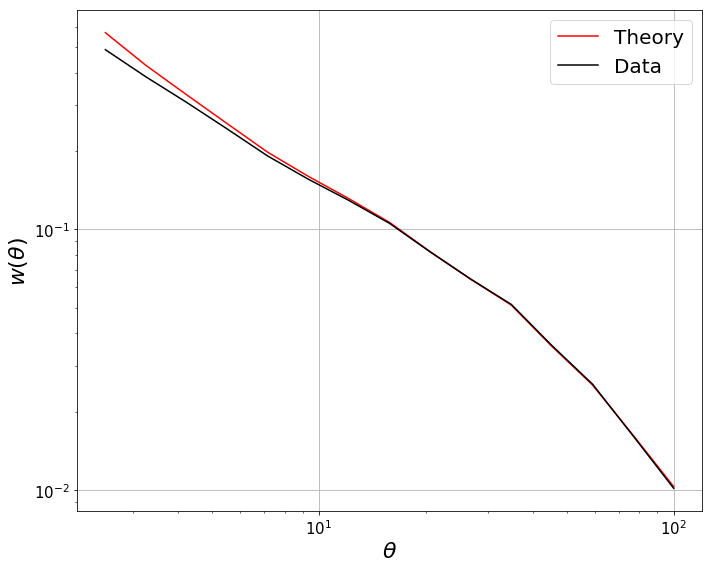

In [23]:
fig, ax = plt.subplots(1,1, figsize = (10,8))


ax.plot(theta_arcmin,wtheta_th, color = 'r', marker='',linestyle='-',label=r'Theory')
ax.plot(theta_arcmin,wtheta_data, color = 'k', marker='',linestyle='-',label=r'Data')


ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(1.0,12.0)
ax.grid()
# ax.set_xlabel(r'$\theta$', size = 18)
ax.set_ylabel(r'$w(\theta)$', size = 22)
ax.set_xlabel(r'$\theta$', size = 22)
ax.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tight_layout()

# savename = ''
# for j in range(len(param_name)):
#     param = param_name[j]
#     param_val = str(param_array_bin1[j])
#     savename += param + param_val + '_'

# print savename

plt.savefig('w_theta_comp.png')







In [36]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=100, Om0=0.25, Tcmb0=2.725, Ob0=0.0448)


dchi_dz_array = (const.c.to(u.km / u.s)).value / (get_Hz(z_array, 0.25))
rhom_z = cosmo.Om0 * ((1 + z_array)**3) * (cosmo.critical_density0.to(u.kg/u.m**3)).value



z_gt0 = np.where(nz_g > 0)[0]
zmin = z_array[z_gt0[0]]
zmax = z_array[z_gt0[-1]]

mean_sig = ptx.get_mean_sig(zmin, zmax, z_array, dchi_dz_array, rhom_z, 0.7)



In [37]:

ind_ltzmax = np.where(z_array <= zmax)[0]
nz_zl = nz_g[ind_ltzmax]
zl_array = z_array[ind_ltzmax]
zs_array = np.linspace(zmax+0.01,1.6,100)



In [38]:

sig_crit_mat = np.zeros((len(zl_array),len(zs_array)))
for j1 in range(len(zl_array)):
    for j2 in range(len(zs_array)):
        sig_crit_mat[j1,j2] = ptx.get_sigcrit_zl_zs(zl_array[j1],zs_array[j2], 0.25)
        
rhom_zl = cosmo.Om0 * ((1 + zl_array)**3) * (cosmo.critical_density0.to(u.kg/u.m**3)).value     
        


In [39]:
zs_max = 1.0
sigs = 0.2
nz_zs = (1/(np.sqrt(2*np.pi*sigs**2)))* np.exp(-1.0 * ( (zs_array - zs_max)**2 / (2*sigs**2) ) )



In [40]:
nz_zs_rep = np.tile(nz_zs.reshape(1,len(zs_array)), (len(zl_array), 1))
int1 = sp.integrate.simps(nz_zs_rep / sig_crit_mat, zs_array)




In [41]:
r_obs_new[1]

array([ 0.89928513,  1.09812453,  1.34269248,  1.65503728,  2.0384615 ,
        2.50953995,  3.08755943,  3.7997315 ,  4.67463926,  5.74993857,
        7.07419699,  8.70099894, 10.70401553, 13.16493016, 16.19262986,
       19.91469461, 24.49334524, 30.12189034, 37.04201222, 45.5515392 ])

In [77]:
r_array_hres = np.logspace(-3,2,1000)
xi_interp = interpolate.interp1d(np.log10(r_obs_new[1]), np.log10(data_obs_new[20:40]*xi_mm[0]), fill_value='extrapolate')
xi_gm_hres = 10**(xi_interp(np.log10(r_array_hres)))

h = 0.7
oneMpc_h = (((10 ** 6) / h) * (u.pc).to(u.m))

gtheta_data = np.zeros(len(theta_rad))

chi_array_zl = get_Dcom_array(zl_array, 0.25)
for j1 in range(len(theta_rad)):
    rp_array = chi_array_zl*theta_rad[j1]
    Deltawp = np.zeros(len(rp_array))
    for j2 in range(len(rp_array)):
        rp = rp_array[j2]
        ind_inp = np.where(r_array_hres > rp)[0]
        r_inp = r_array_hres[ind_inp]
        xi_inp = xi_gm_hres[ind_inp]
#         print rp, r_inp
        Deltawp[j2] = ptx.get_Delta_wp(rp, r_inp,xi_inp, r_array_hres, xi_gm_hres)
    
#     if j1 == len(theta_rad) - 2:
#         pdb.set_trace()
    gtheta_data[j1] = sp.integrate.simps(rhom_zl * nz_zl * int1 * Deltawp  * oneMpc_h, zl_array)
    


In [78]:
r_array_hres = np.logspace(-3,2,1000)
xi_interp = interpolate.interp1d(np.log10(r_obs_new[1]), np.log10(xi_gm[0]), fill_value='extrapolate')
xi_gm_hres = 10**(xi_interp(np.log10(r_array_hres)))

h = 0.7
oneMpc_h = (((10 ** 6) / h) * (u.pc).to(u.m))

gtheta_th = np.zeros(len(theta_rad))

chi_array_zl = get_Dcom_array(zl_array, 0.25)
for j1 in range(len(theta_rad)):
    rp_array = chi_array_zl*theta_rad[j1]
    Deltawp = np.zeros(len(rp_array))
    for j2 in range(len(rp_array)):
        rp = rp_array[j2]
        ind_inp = np.where(r_array_hres > rp)[0]
        r_inp = r_array_hres[ind_inp]
        xi_inp = xi_gm_hres[ind_inp]
#         print rp, r_inp
        Deltawp[j2] = ptx.get_Delta_wp(rp, r_inp,xi_inp, r_array_hres, xi_gm_hres)
    
#     if j1 == len(theta_rad) - 2:
#         pdb.set_trace()
    gtheta_th[j1] = sp.integrate.simps(rhom_zl * nz_zl * int1 * Deltawp  * oneMpc_h, zl_array)



In [79]:
gtheta_data, gtheta_th



(array([0.00181543, 0.00819533, 0.00338934, 0.00287434, 0.00233644,
        0.00181137, 0.00138609, 0.00107224, 0.00090365, 0.00075164,
        0.00059591, 0.00053426, 0.00044889, 0.00037898, 0.0003077 ]),
 array([0.00825543, 0.01024366, 0.00497456, 0.00370522, 0.00281896,
        0.00209708, 0.00156472, 0.00118339, 0.00097443, 0.00079344,
        0.00062249, 0.00054913, 0.00045761, 0.00038132, 0.00030855]))

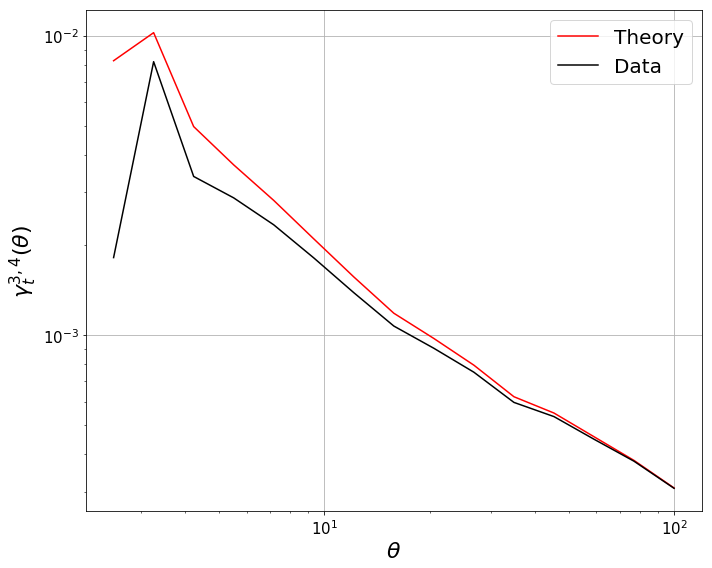

In [80]:
fig, ax = plt.subplots(1,1, figsize = (10,8))


ax.plot(theta_arcmin,gtheta_th, color = 'r', marker='',linestyle='-',label=r'Theory')
ax.plot(theta_arcmin,gtheta_data, color = 'k', marker='',linestyle='-',label=r'Data')


ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(1.0,12.0)
ax.grid()
# ax.set_xlabel(r'$\theta$', size = 18)
ax.set_ylabel(r'$\gamma^{3,4}_t(\theta)$', size = 22)
ax.set_xlabel(r'$\theta$', size = 22)
ax.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.tight_layout()

# savename = ''
# for j in range(len(param_name)):
#     param = param_name[j]
#     param_val = str(param_array_bin1[j])
#     savename += param + param_val + '_'

# print savename

# plt.savefig('w_theta_comp.png')










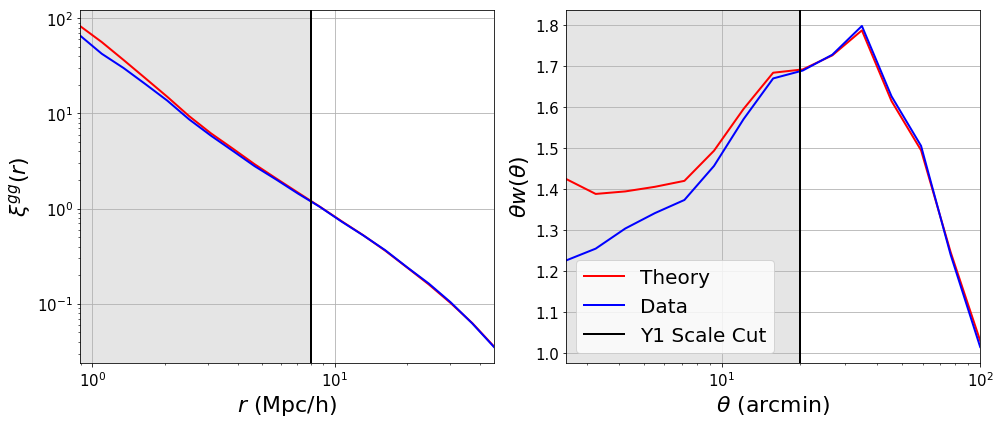

In [99]:
fig, ax_all = plt.subplots(1,2, figsize = (14,6))

for j in range(2):
    ax = ax_all[j]
    if j==0:
        ax.plot(r_obs_new[0],xi_gg[0], color = 'r', lw=2,marker='',linestyle='-',label=r'Theory')
        ax.plot(r_obs_new[0],data_obs_new[0:20]*xi_mm[0], color = 'b',lw=2, marker='',linestyle='-',label=r'Data')
        ax.axvline(8., lw=2, color='k',label='Y1 Scale Cut')
        ax.axvspan(r_obs_new[0][0], 8, alpha=0.1, color='black')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlim(r_obs_new[0][0],r_obs_new[0][-1])
        # ax.set_ylim(1.0,12.0)
        ax.grid()
        # ax.set_xlabel(r'$\theta$', size = 18)
        ax.set_ylabel(r'$\xi^{gg}(r)$', size = 22)
        ax.set_xlabel(r'$r$ (Mpc/h)', size = 22)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)
       
#         ax.legend(fontsize=20)
    else:
        ax.plot(theta_arcmin,theta_arcmin*wtheta_th, color = 'r',lw=2, marker='',linestyle='-',label=r'Theory')
        ax.plot(theta_arcmin,theta_arcmin*wtheta_data, color = 'b',lw=2, marker='',linestyle='-',label=r'Data')
        ax.axvline(20., lw=2, color='k',label='Y1 Scale Cut')
        ax.axvspan(theta_arcmin[0], 20, alpha=0.1, color='k')
        ax.set_xlim(theta_arcmin[0],theta_arcmin[-1])
#         ax.set_yscale('log')
        ax.set_xscale('log')
        # ax.set_ylim(1.0,12.0)
        ax.grid()
        # ax.set_xlabel(r'$\theta$', size = 18)
        ax.set_ylabel(r'$\theta w(\theta)$', size = 22)
        ax.set_xlabel(r'$\theta$ (arcmin)', size = 22)
        ax.legend(fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)

        
        

plt.tight_layout()
plt.savefig('xigg_3d_to_2d_comp_cy.png')






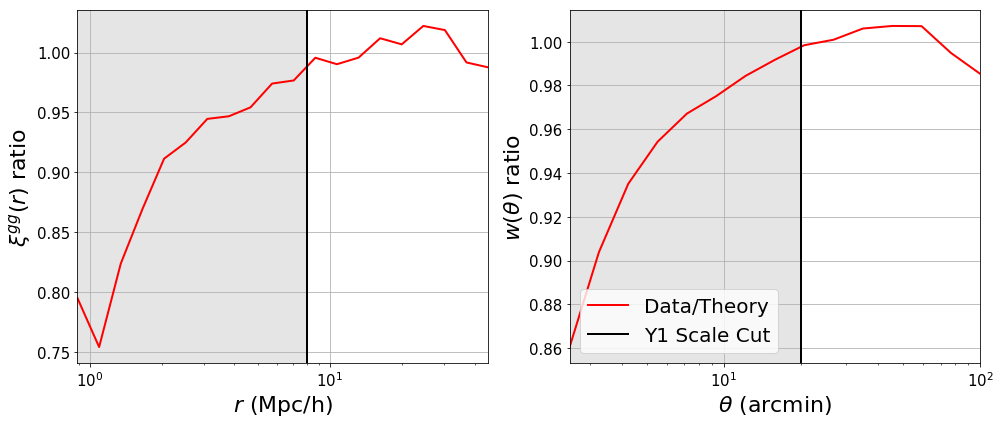

In [100]:
fig, ax_all = plt.subplots(1,2, figsize = (14,6))

for j in range(2):
    ax = ax_all[j]
    if j==0:
        ax.plot(r_obs_new[0],data_obs_new[0:20]*xi_mm[0]/xi_gg[0], color = 'r', lw=2,marker='',linestyle='-',label=r'Data/Theory')
#         ax.plot(r_obs_new[0],data_obs_new[0:20]*xi_mm[0], color = 'b',lw=2, marker='',linestyle='-',label=r'Data')
        ax.axvline(8., lw=2, color='k',label='Y1 Scale Cut')
        ax.axvspan(r_obs_new[0][0], 8, alpha=0.1, color='black')
#         ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlim(r_obs_new[0][0],r_obs_new[0][-1])
        # ax.set_ylim(1.0,12.0)
        ax.grid()
        # ax.set_xlabel(r'$\theta$', size = 18)
        ax.set_ylabel(r'$\xi^{gg}(r)$ ratio', size = 22)
        ax.set_xlabel(r'$r$ (Mpc/h)', size = 22)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)
       
#         ax.legend(fontsize=20)
    else:
        ax.plot(theta_arcmin,wtheta_data/wtheta_th, color = 'r',lw=2, marker='',linestyle='-',label=r'Data/Theory')
#         ax.plot(theta_arcmin,wtheta_data, color = 'b',lw=2, marker='',linestyle='-',label=r'Data')
        ax.axvline(20., lw=2, color='k',label='Y1 Scale Cut')
        ax.axvspan(theta_arcmin[0], 20, alpha=0.1, color='k')
        ax.set_xlim(theta_arcmin[0],theta_arcmin[-1])
#         ax.set_yscale('log')
        ax.set_xscale('log')
        # ax.set_ylim(1.0,12.0)
        ax.grid()
        # ax.set_xlabel(r'$\theta$', size = 18)
        ax.set_ylabel(r'$w(\theta)$ ratio', size = 22)
        ax.set_xlabel(r'$\theta$ (arcmin)', size = 22)
        ax.legend(fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)

        
        

plt.tight_layout()
plt.savefig('xigg_3d_to_2d_ratio.png')







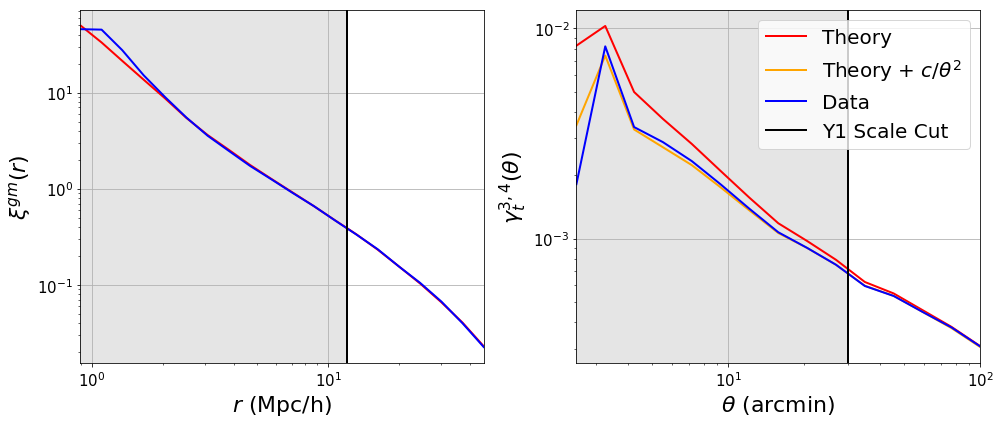

In [102]:
c_by_theta2 = -0.03/(theta_arcmin**2)

fig, ax_all = plt.subplots(1,2, figsize = (14,6))

for j in range(2):
    ax = ax_all[j]
    if j==0:
        ax.plot(r_obs_new[1],xi_gm[0], color = 'r',lw=2, marker='',linestyle='-',label=r'Theory')
        ax.plot(r_obs_new[1],data_obs_new[20:40]*xi_mm[0], lw=2,color = 'b', marker='',linestyle='-',label=r'Data')
        ax.axvline(12., lw=2, color='k',label='Y1 Scale Cut')
        ax.axvspan(r_obs_new[0][0], 12, alpha=0.1, color='black')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlim(r_obs_new[0][0],r_obs_new[0][-1])
        # ax.set_ylim(1.0,12.0)
        ax.grid()
        # ax.set_xlabel(r'$\theta$', size = 18)
        ax.set_ylabel(r'$\xi^{gm}(r)$', size = 22)
        ax.set_xlabel(r'$r$ (Mpc/h)', size = 22)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)
       
#         ax.legend(fontsize=20)
    else:
        ax.plot(theta_arcmin,gtheta_th, color = 'r', lw=2,marker='',linestyle='-',label=r'Theory')
#         ax.plot(theta_arcmin,c_by_theta2, color = 'g', lw=2,marker='',linestyle='--',label=r'$c/\theta^2$')
        ax.plot(theta_arcmin,gtheta_th + c_by_theta2, color = 'orange', lw=2,marker='',linestyle='-',label=r'Theory + ' + r'$c/\theta^2$')
        ax.plot(theta_arcmin,gtheta_data, color = 'b', lw=2,marker='',linestyle='-',label=r'Data')
        ax.axvline(30., lw=2, color='k',label='Y1 Scale Cut')
        ax.axvspan(theta_arcmin[0], 30, alpha=0.1, color='k')
        ax.set_xlim(theta_arcmin[0],theta_arcmin[-1])
        ax.set_yscale('log')
        ax.set_xscale('log')
        # ax.set_ylim(1.0,12.0)
        ax.grid()
        # ax.set_xlabel(r'$\theta$', size = 18)
        ax.set_ylabel(r'$\gamma^{3,4}_t(\theta)$', size = 22)
        ax.set_xlabel(r'$\theta$ (arcmin)', size = 22)
        ax.legend(fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)

        
        

plt.tight_layout()
plt.savefig('xigm_3d_to_2d_comp.png')







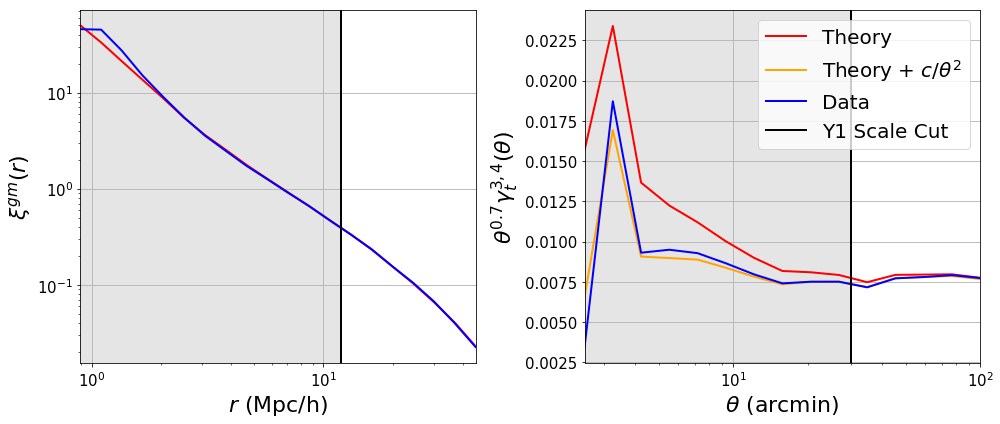

In [101]:
c_by_theta2 = -0.03/(theta_arcmin**2)

fig, ax_all = plt.subplots(1,2, figsize = (14,6))

for j in range(2):
    ax = ax_all[j]
    if j==0:
        ax.plot(r_obs_new[1],xi_gm[0], color = 'r',lw=2, marker='',linestyle='-',label=r'Theory')
        ax.plot(r_obs_new[1],data_obs_new[20:40]*xi_mm[0], lw=2,color = 'b', marker='',linestyle='-',label=r'Data')
        ax.axvline(12., lw=2, color='k',label='Y1 Scale Cut')
        ax.axvspan(r_obs_new[0][0], 12, alpha=0.1, color='black')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlim(r_obs_new[0][0],r_obs_new[0][-1])
        # ax.set_ylim(1.0,12.0)
        ax.grid()
        # ax.set_xlabel(r'$\theta$', size = 18)
        ax.set_ylabel(r'$\xi^{gm}(r)$', size = 22)
        ax.set_xlabel(r'$r$ (Mpc/h)', size = 22)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)
       
#         ax.legend(fontsize=20)
    else:
        ax.plot(theta_arcmin,(theta_arcmin**0.7)*gtheta_th, color = 'r', lw=2,marker='',linestyle='-',label=r'Theory')
#         ax.plot(theta_arcmin,c_by_theta2, color = 'g', lw=2,marker='',linestyle='--',label=r'$c/\theta^2$')
        ax.plot(theta_arcmin,(theta_arcmin**0.7)*(gtheta_th + c_by_theta2), color = 'orange', lw=2,marker='',linestyle='-',label=r'Theory + ' + r'$c/\theta^2$')
        ax.plot(theta_arcmin,(theta_arcmin**0.7)*gtheta_data, color = 'b', lw=2,marker='',linestyle='-',label=r'Data')
        ax.axvline(30., lw=2, color='k',label='Y1 Scale Cut')
        ax.axvspan(theta_arcmin[0], 30, alpha=0.1, color='k')
        ax.set_xlim(theta_arcmin[0],theta_arcmin[-1])
#         ax.set_yscale('log')
        ax.set_xscale('log')
        # ax.set_ylim(1.0,12.0)
        ax.grid()
        # ax.set_xlabel(r'$\theta$', size = 18)
        ax.set_ylabel(r'$\theta^{0.7} \gamma^{3,4}_t(\theta)$', size = 22)
        ax.set_xlabel(r'$\theta$ (arcmin)', size = 22)
        ax.legend(fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='both', which='minor', labelsize=15)

        
        

plt.tight_layout()
plt.savefig('xigm_3d_to_2d_comp_cy.png')








In [160]:
z_array_full = np.linspace(0,2,200)
nz_l_interp = interpolate.interp1d(zl_array,nz_zl,fill_value=0.0,bounds_error=False)
nz_s_interp = interpolate.interp1d(zs_array,nz_zs,fill_value=0.0,bounds_error=False)

nz_l_full = nz_l_interp(z_array_full)
nz_s_full = nz_s_interp(z_array_full)


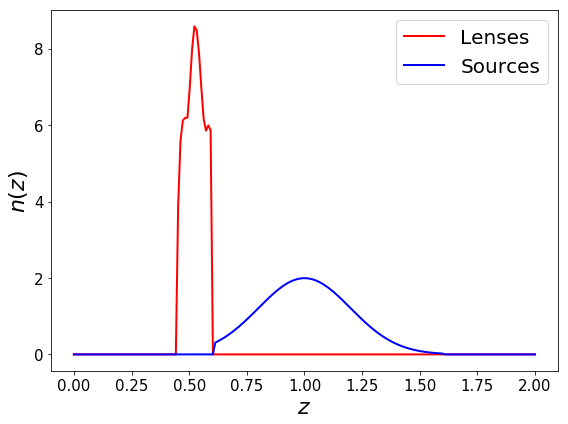

In [164]:
fig, ax_all = plt.subplots(1,1, figsize = (8,6))


ax = ax_all

ax.plot(z_array_full,nz_l_full, color = 'r',lw=2, marker='',linestyle='-',label=r'Lenses')
ax.plot(z_array_full,nz_s_full, color = 'b',lw=2, marker='',linestyle='-',label=r'Sources')

ax.set_ylabel(r'$n(z)$', size = 22)
ax.set_xlabel(r'$z$', size = 22)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)  
ax.legend(fontsize=20)

plt.tight_layout()
plt.savefig('nz_comp.png')










In [3]:
twopt_file = fits.open('/Users/shivam/Downloads/tpt_rot1_vY1_sn_wcov.fits')



In [4]:
twopt_file.info()


Filename: /Users/shivam/Downloads/tpt_rot1_vY1_sn_wcov.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       4   ()      
  1  xip         BinTableHDU     36   200R x 7C   [K, K, K, D, D, D, D]   
  2  xim         BinTableHDU     36   200R x 7C   [K, K, K, D, D, D, D]   
  3  gammat      BinTableHDU     36   400R x 7C   [K, K, K, D, D, D, D]   
  4  wtheta      BinTableHDU     36   300R x 7C   [K, K, K, D, D, D, D]   
  5  nz_shear_true  BinTableHDU     32   265R x 7C   [D, D, D, D, D, D, D]   
  6  nz_pos_zrm  BinTableHDU     31   1999R x 8C   [D, D, D, D, D, D, D, D]   
  7  nz_pos_zspec  BinTableHDU     31   1999R x 8C   [D, D, D, D, D, D, D, D]   
  8  COV_CLIKE_G  ImageHDU        17   (1100, 1100)   float64   


In [14]:
z_mid = twopt_file['nz_shear_true'].data['Z_MID']
bin4 = twopt_file['nz_shear_true'].data['BIN4']
int_b4 = sp.integrate.simps(bin4,z_mid)
nz_b4 = bin4/int_b4


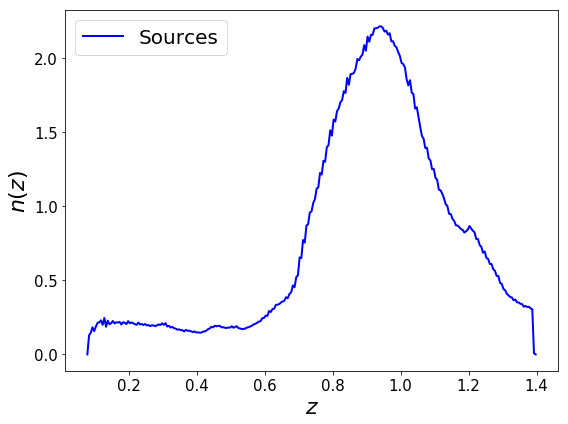

In [15]:

fig, ax_all = plt.subplots(1,1, figsize = (8,6))


ax = ax_all

ax.plot(z_mid,nz_b4, color = 'b',lw=2, marker='',linestyle='-',label=r'Sources')

ax.set_ylabel(r'$n(z)$', size = 22)
ax.set_xlabel(r'$z$', size = 22)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)  
ax.legend(fontsize=20)

plt.tight_layout()
# plt.savefig('nz_comp.png')








In [2]:
twopt = fits.open('/home/shivam/Research/cosmosis/y3kp-bias-model/3d_stats/3d_to_2d/twopt_mice_y1_specz_mod.fits')

twopt.info()


Filename: /home/shivam/Research/cosmosis/y3kp-bias-model/3d_stats/3d_to_2d/twopt_mice_y1_specz_mod.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xip           1 BinTableHDU     36   200R x 7C   [K, K, K, D, D, D, D]   
  2  xim           1 BinTableHDU     36   200R x 7C   [K, K, K, D, D, D, D]   
  3  gammat        1 BinTableHDU     36   400R x 7C   [K, K, K, D, D, D, D]   
  4  wtheta        1 BinTableHDU     36   300R x 7C   [K, K, K, D, D, D, D]   
  5  nz_shear_true    1 BinTableHDU     32   265R x 7C   [D, D, D, D, D, D, D]   
  6  nz_pos_zrm    1 BinTableHDU     31   1999R x 8C   [D, D, D, D, D, D, D, D]   
  7  nz_pos_zspec    1 BinTableHDU     31   1999R x 8C   [D, D, D, D, D, D, D, D]   
  8  COV_CLIKE_G    1 ImageHDU        17   (1100, 1100)   float64   
